### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:02 (МСК)

### Переходим к практике

In [549]:
import pandas as pd

Наши новости

In [550]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [551]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [15]:
!pip install -qq gensim razdel

In [552]:
!pip -qq install pymorphy2
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [553]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [554]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [555]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [556]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [557]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [558]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: total: 15.4 s
Wall time: 15.5 s


In [559]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 2min 2s
Wall time: 2min 2s


А теперь в 3 строчки обучим нашу модель

In [560]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [202]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [561]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary, passes=10)

CPU times: total: 5min 54s
Wall time: 6min 40s


In [562]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [563]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.048638754),
 (8, 0.044366475),
 (10, 0.07324871),
 (12, 0.09244948),
 (17, 0.48263168),
 (20, 0.24211426)]

In [36]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: статья около год восток который тыс человек
topic_1: год россия это который источник российский мочь
topic_2: год млрд рубль млн россия составить тыс
topic_3: российский россия год который это наука путин
topic_4: проверка солнце студент учебный заведение снижение автобус
topic_5: поверхность конкурс тыс год супруг фонд стол
topic_6: украина украинский космос киев общество мышь атмосферный
topic_7: военный территория участок торговый операция nn боевой
topic_8: погибнуть объект проверка свет комплекс спасти гостиница
topic_9: это год который страна россия nn также
topic_10: который исследование это свой научный мочь год
topic_11: место взрыв журнал квартира nn рейтинг население
topic_12: район пострадать армия век высота специальный миссия
topic_13: опрос параметр озеро реакция грунт надёжный приоритетный
topic_14: газ журнал банк это медведев президент который
topic_15: ракета километр земля су стрельба орудие тело
topic_16: температура градус климат соцсеть общество пляж лес

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [564]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [262]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.111458,0.0,0.000000,0.000000,0.0,0.000000
1,4896,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.368925,0.0,0.000000,0.000000,0.0,0.000000
2,4897,0.0,0.0,0.000000,0.046372,0.0,0.137502,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.424745,0.0,0.075516,0.182748,0.0,0.000000
3,4898,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.315851,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.146766,0.0,0.000000,0.393360,0.0,0.082654
4,4899,0.0,0.0,0.393683,0.000000,0.0,0.000000,0.000000,0.0,0.215042,...,0.0,0.0,0.0,0.0,0.079956,0.0,0.000000,0.000000,0.0,0.175297


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [39]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [40]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [86]:
doc_dict[6]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.88007575,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11145663,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [42]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [43]:
get_user_embedding(user_articles_list)

array([0.01797001, 0.06958709, 0.05200394, 0.18048509, 0.00773662,
       0.00603801, 0.        , 0.05978692, 0.        , 0.147135  ,
       0.04911667, 0.03067151, 0.00249602, 0.00369588, 0.02638906,
       0.        , 0.        , 0.        , 0.00394319, 0.        ,
       0.02913744, 0.16144847, 0.04946175, 0.02273329, 0.06795155])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [82]:
#users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [88]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать бара

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.097117,0.071986,0.052955,0.006980,0.009728,0.043942,0.004459,0.003009,...,0.009443,0.000000,0.01118,0.015116,0.000000,0.215479,0.113445,0.036527,0.002455,0.137601
1,u108690,0.021427,0.065560,0.045988,0.100314,0.005363,0.014268,0.082943,0.009326,0.000000,...,0.000000,0.000000,0.00000,0.007301,0.003109,0.087686,0.114419,0.063893,0.004457,0.013165
2,u108339,0.042176,0.044106,0.055940,0.024330,0.000000,0.005862,0.000000,0.049994,0.024733,...,0.000000,0.005941,0.00000,0.009864,0.000000,0.166888,0.144098,0.012871,0.004590,0.023899


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [45]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [46]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.097117,0.071986,0.052955,0.006980,0.009728,0.043942,0.004459,0.003009,...,0.000000,0.01118,0.015116,0.000000,0.215479,0.113445,0.036527,0.002455,0.137601,0
1,u108690,0.021427,0.065560,0.045988,0.100314,0.005363,0.014268,0.082943,0.009326,0.000000,...,0.000000,0.00000,0.007301,0.003109,0.087686,0.114419,0.063893,0.004457,0.013165,1
2,u108339,0.042176,0.044106,0.055940,0.024330,0.000000,0.005862,0.000000,0.049994,0.024733,...,0.005941,0.00000,0.009864,0.000000,0.166888,0.144098,0.012871,0.004590,0.023899,1


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [49]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [50]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16753699, 0.0361867 , 0.34473303, 0.14256656, 0.06033619,
       0.04967426, 0.13908895, 0.05195252, 0.1141936 , 0.26845023])

In [51]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.205556, F-Score=0.639, Precision=0.506, Recall=0.865


In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1548  207]
 [  34  211]]


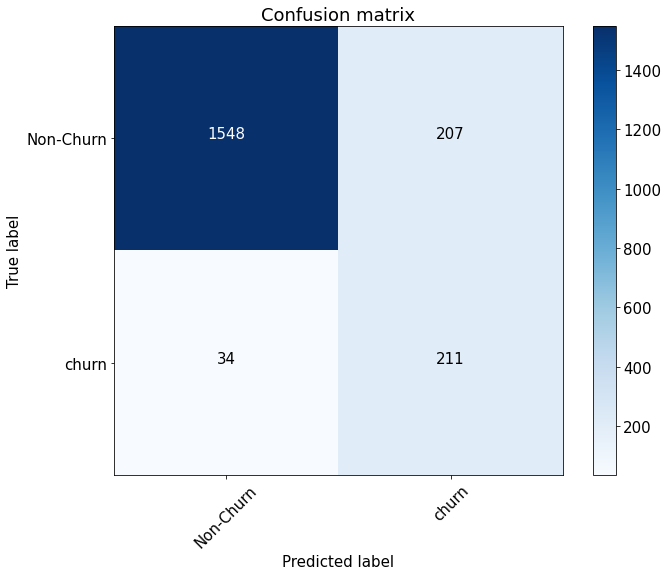

In [56]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [57]:
roc_auc_score(y_test, preds)

0.9357311471597186

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

## Homework
### changed $LDA = 10$ passes, $n_{topics} = 20$

Задание № 1: повторил

Задание № 2, 3

In [756]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from lightgbm import LGBMClassifier

In [757]:
y_train.value_counts(normalize=True)

0    0.875
1    0.125
Name: churn, dtype: float64

In [758]:
data = pd.DataFrame(columns=['roc_auc', 'precision', 'recall', 'f_score', 'threshold'], 
                    index=['mean', 'median', 'max', 'tfidf'])

In [769]:
def get_user_embedding(user_articles_list, agg='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if agg == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif agg == 'median':
        user_vector = np.median(user_vector, 0)
    elif agg == 'max':
        user_vector = np.max(user_vector, 0)
    else:
        raise ValueError(f'parameter "arg" shoud be "mean", "median" or "max", {agg} is given.')
    return user_vector

In [772]:
def evaluate_users(agg: str):
    print(f'Evaluate with "{agg}" parameter.')
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, agg=agg), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], shuffle=True, stratify=X['churn'], random_state=0)
    logreg = make_pipeline(SMOTE(sampling_strategy=.8, random_state=42),
                           LogisticRegression(class_weight='balanced', random_state=42)).fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, preds)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    print(f'ROC_AUC score: {roc_auc:.3f}')
    data.loc[agg, :] = [roc_auc, precision[ix], recall[ix], fscore[ix], thresholds[ix]]

In [773]:
for agg in ('mean', 'median', 'max'):
    evaluate_users(agg=agg)
    print('-'*50)

Evaluate with "mean" parameter.
Best Threshold=0.687459, F-Score=0.658, Precision=0.603, Recall=0.724
ROC_AUC score: 0.941
--------------------------------------------------
Evaluate with "median" parameter.
Best Threshold=0.734988, F-Score=0.707, Precision=0.687, Recall=0.728
ROC_AUC score: 0.953
--------------------------------------------------
Evaluate with "max" parameter.
Best Threshold=0.784410, F-Score=0.830, Precision=0.862, Recall=0.800
ROC_AUC score: 0.982
--------------------------------------------------


Задание № 4

In [590]:
# попытка немного осмыслить, что происходит в "черном ящике"
from collections import Counter

def idf_user_vector(user_articles_list):
    user_articles_list = eval(user_articles_list)
    n_docs = len(user_articles_list)  # number of documents
    df = {}
    for i in range(n_docs):  # number of docs from docs set that contain particular term
        tokens = news.loc[news.doc_id == user_articles_list[i], 'title'].values[0]
        for token in tokens:
            try:
                df[token].add(i)
            except:
                df[token] = {i}
    out_tokens = []
    for i in range(n_docs):  # number of term occurances in each doc
        tokens = news.loc[news.doc_id == user_articles_list[i], 'title'].values[0]
        token_occurances = Counter(tokens)
        idf = [np.log(n_docs / (1 + len(df[token]))) for token in tokens]
        tfidf = np.array([token_occurances[token]*idf[j] for j, token in enumerate(tokens)]) # tf * idf
        tfidf /= np.linalg.norm(tfidf, ord=2)
        out_tokens.append(tfidf.tolist())
    
    return out_tokens

In [762]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [763]:
vectorizer = TfidfVectorizer()
vector = users['articles'].apply(lambda x: x[1:-1].replace(',', ''))
    
weights = vectorizer.fit_transform(vector)

weights_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names_out(), columns=['weights'])

In [764]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    weights = []
    for doc_id in user_articles_list:
        try:
            weights.append(weights_idf.loc[str(doc_id)].values[0])
        except:
            weights.append(0.)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    
    user_vector = np.median(user_vector * np.array(weights).reshape(-1,1), 0)

    return user_vector

In [765]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], shuffle=True, stratify=X['churn'], random_state=0)
X.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.738319,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,1.925768,0.228478,0.175047,0.0,0.481328,0
1,u108690,0.207747,0.192396,0.080957,0.672732,0.0,0.0,0.349891,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.594747,0.418793,0.627784,0.0,0.051417,1
2,u108339,0.193398,0.401334,0.221408,0.131677,0.0,0.0,0.000000,0.092215,0.19074,...,0.0,0.0,0.0,0.000000,1.509696,1.050512,0.060446,0.0,0.198172,1
3,u101138,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,2.422475,0.000000,0.000000,0.651777,0.0,0.000000,0
4,u108248,0.506206,0.860363,0.208588,0.581389,0.0,0.0,0.055254,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.725269,0.258779,0.312525,0.0,0.149526,1


In [766]:
logreg = make_pipeline(SMOTE(sampling_strategy=0.7, random_state=42),
                       LogisticRegression(class_weight='balanced', random_state=42)).fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
print(f'ROC_AUC score: {roc_auc:.3f}')
data.loc['tfidf', :] = [roc_auc, precision[ix], recall[ix], fscore[ix], thresholds[ix]]

Best Threshold=0.870687, F-Score=0.826, Precision=0.827, Recall=0.824
ROC_AUC score: 0.981


Задание №5

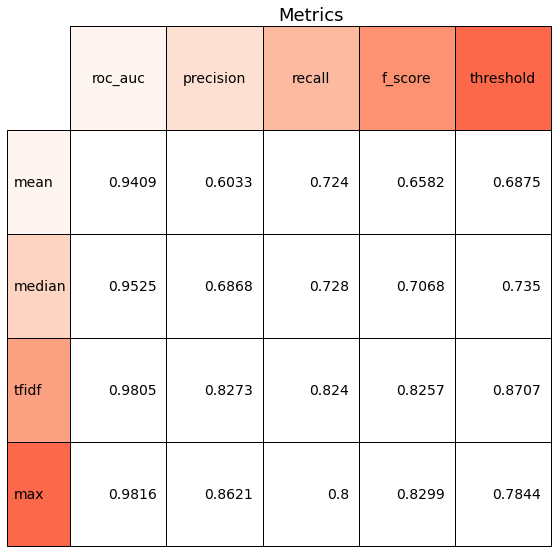

In [767]:
plt.figure(figsize=(8,8))
colors_cols = plt.cm.Reds(np.linspace(0, 0.5, len(data)+1))
colors_rows = plt.cm.Reds(np.linspace(0, 0.5, len(data)))

data.sort_values(by='roc_auc', inplace=True)
values = np.round(data.values.astype(np.float32), decimals=4)
the_table = plt.table(cellText=values,
                      rowColours=colors_rows,
                      colColours=colors_cols,
                      rowLabels=data.index,
                      colLabels=data.columns,
                      loc='bottom',
                      bbox=[0,0,1.,1.],
                      )
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)
the_table.scale(3, 3)
plt.xticks([])
plt.yticks([])
plt.title('Metrics')
plt.tight_layout()
plt.show()

Задание №6

#### Лучший результат дала модель с применением  max. Интуитивно понятно, что применение максимальных значений к невзвешенным документам выделяет все признаки (темы), наиболее релевантные пользователю, наличие которых больше влияет на целевую переменную.

### Optional

In [768]:
lgbm = LGBMClassifier(verbose=-1, 
                      max_depth=3, 
                      n_estimators=300, 
                      n_jobs=-1, 
                      learning_rate=0.1, 
                      boosting_type='gbdt',
                      random_state=42)
lgbm.fit(X_train, y_train)
preds = lgbm.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
print(f'ROC_AUC score: {roc_auc:.3f}')

Best Threshold=0.456827, F-Score=0.940, Precision=0.940, Recall=0.940
ROC_AUC score: 0.997
